In [1]:
import numpy as np
"""from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive/YYY_deep_project_YYY'"""


"from google.colab import drive\ndrive.mount('/content/drive')\n!ls drive/'My Drive/YYY_deep_project_YYY'"

In [2]:
#%cd drive/'My Drive/YYY_deep_project_YYY'

In [3]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

221


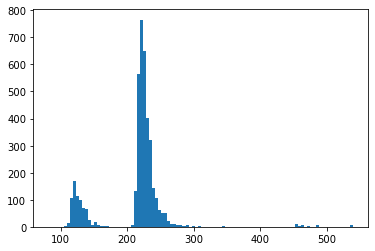

In [4]:
sequences = []
seq_to_pdb = {}
count = 0
with open('all_heavy.fasta') as infile:

        for header, sequence, pdb in get_sequence(infile):
            #if count < 500:
            sequences.append(list(sequence))
                #count += 1
            
            seq_to_pdb[sequence] = pdb
            
#sequences = [seq for seq in sequences if len(seq) < 150]

import matplotlib.pyplot as plt
lengths = [len(seq) for seq in sequences]

mode = max(set(lengths), key=lengths.count)

print(mode)

plt.hist(lengths, bins=100)
plt.show()
#sequences = [seq for seq in sequences if len(seq) == mode]

# Take only shorter sequences to make it more quick



In [5]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train-1]
    sequences_val = sequences[num_train:num_train+num_val-1]
    sequences_test = sequences[-num_test:-1]

    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]

    return (input_train, input_val, input_test)

(input_train, input_val, input_test) = create_datasets(sequences, Dataset)

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        
        self.ff = nn.Linear(ninp, ntoken)

        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embed.weight.data.uniform_(-initrange, initrange)
        
        self.ff.bias.data.zero_()
        self.ff.weight.data.uniform_(-initrange, initrange)
        
        #self.transformer_decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask, seq_lengths):
        
        # utils.rnn lets you give (B,L,D) tensors where B is the batch size, L is the maxlength, if you use batch_first=True
        # Otherwise, give (L,B,D) tensors
        #seq_tensor = src.transpose(0,1) # (B,L,D) -> (L,B,D)
        
        seq_tensor = src
        # embed your sequences
        seq_tensor = self.embed(seq_tensor) * math.sqrt(self.ninp)
        
        # pack them up nicely
        #packed_input = pack_padded_sequence(seq_tensor, seq_lengths.numpy())
        
        src = self.pos_encoder(seq_tensor)
        
        output = self.transformer_encoder(src, src_mask)

        #output = self.transformer_decoder(output, src_mask)
        output = self.ff(output)

        return output

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:

def generate_square_subsequent_mask(sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}

def batchify(data):
    
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])

    train_vectorized = [[char_nums[char] for char in seq] for seq in data]
    
    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    seq_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()
    for idx, (seq, seqlen) in enumerate(zip(train_vectorized, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    # SORT YOUR TENSORS BY LENGTH!
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    return seq_tensor, seq_lengths


train_data, train_lengths = batchify(input_train)
val_data, val_lengths = batchify(input_train)
test_data, test_lengths = batchify(input_train)

train_data

tensor([[ 1, 16, 20,  ...,  6,  3,  2],
        [ 1, 16, 20,  ...,  6,  3,  2],
        [ 1, 16, 20,  ...,  6,  3,  2],
        ...,
        [ 1, 18,  8,  ...,  0,  0,  0],
        [ 1,  8, 20,  ...,  0,  0,  0],
        [ 1, 18, 13,  ...,  0,  0,  0]])

In [9]:
bptt = 80
max_len = max(map(len, sequences))
def get_batch(source, i):
    n_seqs = min(bptt, len(source) - 1 - i)
    data = torch.cat([train_data[i][:-1] for i in range(n_seqs)]).view(n_seqs,max_len+1)
    
    target = torch.cat([train_data[i][1:] for i in range(n_seqs)]).view(n_seqs,max_len+1).reshape(-1)
    
    return data, target


In [10]:
ntokens = len(vocab) # the size of vocabulary
emsize = 800 # embedding dimension
nhid = 400 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.5 # the dropout value

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()

lr = 5.5 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer  = torch.optim.Adam(lr=lr, params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model.to(device)
import sys
import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(vocab)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)

    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_data, i)
    
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        
        output = model(data, src_mask, train_lengths)
        
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 1
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}|'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask, val_lengths)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)


In [12]:
best_val_loss = float("inf")
epochs = 20 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/Users/jonas/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     1/   40 batches | lr 5.50 | ms/batch 114145.43 | loss 18.44 | ppl 101859603.57|


KeyboardInterrupt: 

In [ ]:
#orch.save(model,'C:/Users/jonas/Desktop/deep_project/models/model.py')
# Model class must be defined somewhere
#model = torch.load("models/model.py", map_location=torch.device('cpu'))
#model.eval()

#best_model = model

In [154]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  1.87 | test ppl     6.50


In [172]:
idx_to_letter = {val:key for key, val in char_nums.items()}

def sample_categorical(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=1)

    #print("softmaxed probs:", p)
    
    return dist.Categorical(p).sample()

def sample_sentence(model, query, max_len = 140, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while len(query) < max_len and '<eos>' not in query:
        query_tensor, seq_lengths = batchify([query])
        
        
        src_mask = model.generate_square_subsequent_mask(len(query_tensor)).to(device)
        
        
        output = model(query_tensor, src_mask, torch.Tensor([len(query)])).view(-1, ntokens)
        
     
        next_char_idx = sample_categorical(output, temperature) #0.5
     
    
        try:
            query += [idx_to_letter[int(next_char_idx[-1])]]
        except IndexError:
            query += [idx_to_letter[int(next_char_idx)]]
            
    return query


In [173]:
import torch.distributions as dist


In [175]:
import torch.distributions as dist
ntokens = len(vocab)



#dat = batchify(['<sos>'], 1)

#print(" ".join(sample))

for _ in range(10):
    sample = sample_sentence(model, ["E"], max_len = 300, temperature=0.9)

    print(len(sample), " ".join(sample))
    

82 E D T Y Y G G G G G G E G G G G G G K N I S L L A V S S L T D T T T Y A A Y F R F T Y Y D N D T Y A M N N S S V S L S L Y C Y Y G G G G G G G G L S G W G G G G V <eos>
108 E A T S S T Y A G V G G G G E D T Y T S A A V T S S L S S L S S S S L S S S L S S G G G V S G G G P G S L S S L Y Y A Y Y Y Y T Y Y Y Y Y D T Y Y S S S S S S D T Y D T Y Y Y Y S S N N Q S G G G F T Y Y Y Y Y Y G H <eos>
300 E I S L S S S P G V S N R F T I S S S S L T Y G G G G S T Y Y Y S N D N L S S L K N T T Y S S S S S S S S S T S S G G G G G T S S S D T T Y D T Y D T Y Y Y T Y Y Y D T Y F T N W W I N Y Y Y Y Y A A V S S L S L R C A S S G G G G G Y Y Y Y L S V S I D N S S G V W W W F T Y L C A C A V S G G Y C A C A K L S S V S D N A C C T T Y C A S T Y Y Y L S L S S L S K N S S N Y A V Q V T I R F T Q L S L S K P G G G G V A K N Q S S N A D N T Y Y Y G N T Y Y N S P G V T Y Y W F I N Y W A G G S S A V S T Y Y W I S S K N T S S A V Q N Y L S N S N A A F T Y Y Y L Y Y C A G T Y Y A M N A M N S N S L S T Y Y Y S
6